In [94]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import joblib
from sklearn.svm import SVC
from sklearn.preprocessing import OrdinalEncoder
from sklearn.feature_selection import RFE
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RepeatedKFold
from sklearn.linear_model import Lasso
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder, PolynomialFeatures
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import PolynomialFeatures
from sklearn.pipeline import Pipeline 
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import classification_report
from sklearn.model_selection import cross_val_predict
from sklearn.linear_model import LogisticRegression
from scipy.stats import expon
from sklearn.metrics import precision_score, recall_score
from sklearn.metrics import precision_recall_curve
from scipy import stats
from sklearn.metrics import f1_score
from sklearn.metrics import accuracy_score
from sklearn.metrics import r2_score
import datetime
from time import time
import warnings
from sklearn.decomposition import PCA
from sklearn.manifold import MDS
from sklearn.manifold import LocallyLinearEmbedding as LLE
from scipy.spatial.distance import squareform
from scipy.spatial.distance import pdist
from sklearn.manifold import Isomap
warnings.filterwarnings('ignore')
from sklearn.model_selection import train_test_split
import numpy as np
import matplotlib.pyplot as plt
plt.style.use('bmh')


# Loading the data

In [95]:

data = pd.read_csv('dgemm_data.csv')
selected_columns = ['ctdp_in_watts', 'cpufreq_scaling_governor', 'power_determinism_mode_enabled',
                     'numa_zones', 'packages', 'total_memory_size_in_gib', 'memory_speed_in_mts',
                     'M', 'N', 'K', 'gflops']

# Filter relevant columns
data = data[selected_columns]
#longitude_np = housing['longitude'].to_numpy()
#longitude_np.shape
regression_data = pd.DataFrame(data)
regression_data


,ctdp_in_watts,cpufreq_scaling_governor,power_determinism_mode_enabled,numa_zones,packages,total_memory_size_in_gib,memory_speed_in_mts,M,N,K,gflops
0,-1.0,performance,False,2,2,1536,4800,16000,16000,16000,4527.48
1,-1.0,performance,False,2,2,1536,4800,16000,16000,16000,4581.91
2,-1.0,performance,False,2,2,1536,4800,16000,16000,16000,4577.75
3,-1.0,performance,False,2,2,1536,4800,16000,16000,16000,4583.39
4,-1.0,performance,False,2,2,1536,4800,16000,16000,16000,4464.09
...,...,...,...,...,...,...,...,...,...,...,...
15983,-1.0,performance,False,2,2,1536,5600,16000,16000,16000,14779.58
15984,-1.0,performance,False,2,2,1536,5600,16000,16000,16000,12830.87
15985,-1.0,performance,False,2,2,1536,5600,16000,16000,16000,12650.08
15986,-1.0,performance,False,2,2,1536,5600,16000,16000,16000,13900.91


# Load the model

In [96]:
import pickle

# Load the model using pickle
with open('RandomForestRegressor.pkl', 'rb') as file:
    loaded_model = pickle.load(file)
print(type(loaded_model))

<class 'sklearn.pipeline.Pipeline'>


In [97]:
from sklearn.model_selection import train_test_split

In [98]:
memory_cat = pd.cut(regression_data['memory_speed_in_mts'],
 bins=[0,1500,3000, 4500, 5000, np.inf],
 labels=[1, 2, 3, 4, 5])
memory_cat

0        4
1        4
2        4
3        4
4        4
        ..
15983    5
15984    5
15985    5
15986    5
15987    5
Name: memory_speed_in_mts, Length: 15988, dtype: category
Categories (5, int64): [1 < 2 < 3 < 4 < 5]

In [99]:
train_set, test_set, memory_cat_train, memory_cat_test = train_test_split(regression_data,memory_cat,test_size=0.2,
                                                                          shuffle=True,
                                                                          random_state=42,
                                                                          stratify=memory_cat)

#train_set, test_set = train_test_split(regression_data,test_size=0.2,shuffle=True,random_state=42)


In [100]:
t_train = train_set['gflops'].copy()
X_train = train_set.drop(labels='gflops', axis=1)
# axis=1 means it's a column in the dataframe

t_train.shape, X_train.shape

((12790,), (12790, 10))

In [101]:
t_test = test_set['gflops'].copy()
X_test = test_set.drop(labels='gflops', axis=1)

t_test.shape, X_test.shape

((3198,), (3198, 10))

In [102]:
X_train.info()

<class 'pandas.core.frame.DataFrame'>
Index: 12790 entries, 13512 to 4301
Data columns (total 10 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   ctdp_in_watts                   12790 non-null  float64
 1   cpufreq_scaling_governor        12790 non-null  object 
 2   power_determinism_mode_enabled  12790 non-null  bool   
 3   numa_zones                      12790 non-null  int64  
 4   packages                        12790 non-null  int64  
 5   total_memory_size_in_gib        12790 non-null  int64  
 6   memory_speed_in_mts             12790 non-null  int64  
 7   M                               12790 non-null  int64  
 8   N                               12790 non-null  int64  
 9   K                               12790 non-null  int64  
dtypes: bool(1), float64(1), int64(7), object(1)
memory usage: 1011.7+ KB


# Predictions

In [103]:
y_train = loaded_model.predict(X_train)
y_test = loaded_model.predict(X_test)
y_train
y_test

array([3316.45337022,   29.44373963, 6202.41041136, ..., 6202.41041136,
       6202.41041136, 7680.03588471])

# Lets Deep into Accuracy Evaluations

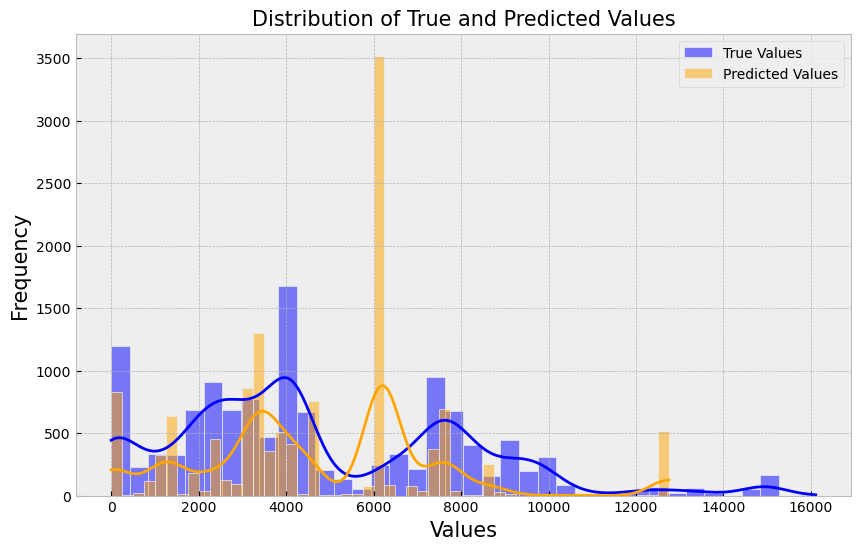

In [104]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
sns.histplot(t_train, label='True Values', kde=True, color='blue')
sns.histplot(y_train, label='Predicted Values', kde=True, color='orange')
plt.xlabel('Values', size=15)
plt.ylabel('Frequency', size=15)
plt.title('Distribution of True and Predicted Values', size=15)
plt.legend()
plt.show()

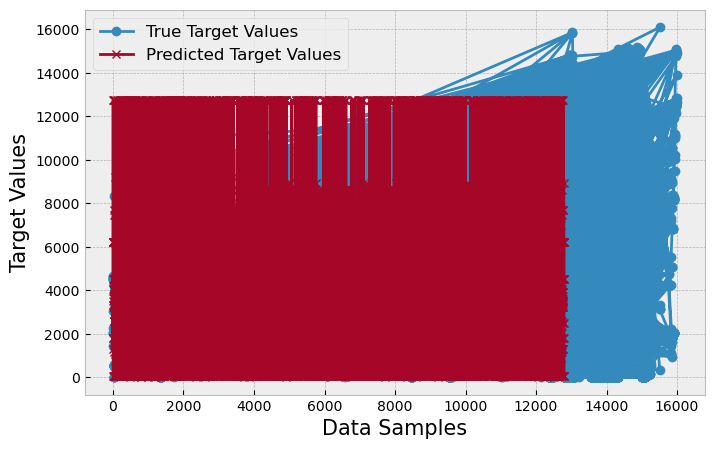

In [105]:
import matplotlib.pyplot as plt

# Assuming 't_train' contains the true target values and 'y_train' contains the predicted values
plt.figure(figsize=(8, 5))
plt.plot(t_train, label='True Target Values', marker='o')
plt.plot(y_train, label='Predicted Target Values', marker='x')
plt.xlabel('Data Samples', size=15)
plt.ylabel('Target Values', size=15)
plt.legend(fontsize=12)
plt.show()


In [106]:
mse_train = mean_squared_error(t_train, y_train)
rmse_train = np.sqrt(mse_train)

print('RMSE Training Set: ', rmse_train)

mse_test = mean_squared_error(t_test, y_test)
rmse_test = np.sqrt(mse_train)

print('RMSE Testing Set: ', rmse_test)

RMSE Training Set:  1809.2964773591366
RMSE Testing Set:  1809.2964773591366


In [108]:
from sklearn.metrics import r2_score

# Assuming y_true contains the actual target values and y_pred contains the predicted values
r_squared = r2_score(t_train, y_train)

print(f'R-squared: {r_squared}')


R-squared: 0.7018152803185214
